In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
os.chdir("src")

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

from sklearn.metrics import mean_squared_error

from utils import read_csv, split_by_underscores, filter_columns, set_style
from constants import DATA_PATH, SEP_CSV

from anomaly_detection import *
from utils import *
from data_preparation import *

In [19]:
os.chdir("../")

In [20]:
# Update get_data function to reach the specified data by grouping country and brand
def get_data_byGrouping(country, brand):
    global df_raw
    # Read time series data.
    df_raw = read_csv(DATA_PATH, SEP_CSV)
    # Split c_SMP_KEY.
    column = 'c_SMP_KEY'
    split_columns = split_by_underscores(df_raw[column])
    df_prep = pd.DataFrame({f"c_FEATURE_{i + 1}": split_column for i, split_column in enumerate(split_columns)})
    df_prep['c_VALUE'] = df_raw['c_VALUE']
    # Format as datetime.
    df_prep['c_DATE'] = pd.to_datetime(df_raw['c_DATE'], format='%Y%m')
    # Set the 'c_DATE' column as the index.
    df_prep.set_index('c_DATE', inplace=True)
    # Filter the DataFrame based on country and brand
    df_filtered = df_prep[(df_prep['c_FEATURE_1'] == country) & (df_prep['c_FEATURE_2'] == brand)]
    return df_filtered

In [21]:
# Specify the country and brand for analysis
country = 'Deutschland'
brand = 'BMW'

# Deutschland BMW
# Data Preparation
df = get_data_byGrouping(country, brand)

In [22]:
# Calculate yearly sum of c_VALUE
yearly_sum = df['c_VALUE'].resample('YS').sum()
# print(yearly_sum)
print(len(yearly_sum))

43


In [23]:
# Normalize the data
scaler = MinMaxScaler()
yearly_sum = scaler.fit_transform(yearly_sum.values.reshape(-1, 1))

In [24]:
# Define the number of previous years to use as input for the LSTM model
lookback = 10

# Prepare the input and output data
X, y = [], []
for i in range(lookback, len(yearly_sum)):
    X.append(yearly_sum[i - lookback:i, 0])
    y.append(yearly_sum[i, 0])

X, y = np.array(X), np.array(y)

if X.shape[0] < lookback:
    raise ValueError("Not enough data points for the given lookback value.")

# Reshape the input data for LSTM (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [25]:
# Build and train the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(lookback, 1), activation='tanh', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.fit(X, y, epochs=50, batch_size=64)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.9999 - mse: 0.7006
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 0.9400 - mse: 0.6459
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 0.8109 - mse: 0.5211
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 0.6847 - mse: 0.3990
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 0.5984 - mse: 0.3167
Epoch 6/50
1/1 [==============================] - 0s 9ms/step - loss: 0.5073 - mse: 0.2294
Epoch 7/50
1/1 [==============================] - 0s 9ms/step - loss: 0.4030 - mse: 0.1288
Epoch 8/50
1/1 [==============================] - 0s 9ms/step - loss: 0.3561 - mse: 0.0854
Epoch 9/50
1/1 [==============================] - 0s 10ms/step - loss: 0.3150 - mse: 0.0478
Epoch 10/50
1/1 [==============================] - 0s 9ms/step - loss: 0.3010 - mse: 0.0374
Epoch 11/50
1/1 [==============================] - 0s 9ms/step - loss: 0.3302 - mse: 0.07

In [26]:
# Calculate yearly sum of c_VALUE
yearly_sum = df['c_VALUE'].resample('YS').sum()

# Make predictions for the available data
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)
print(len(predictions))

# Create a DataFrame for the predictions
predictions_years = yearly_sum.index[lookback:]  # Use the corresponding years for predictions
predictions_df = pd.DataFrame({'Year': predictions_years, 'Predicted Car Registrations': predictions.flatten()})

# Extract the year component from the 'Year' column
predictions_df['Year'] = predictions_df['Year'].dt.year

# Print the predictions DataFrame
print(predictions_df)

2/2 [==============================] - 0s 3ms/step
33
    Year  Predicted Car Registrations
0   1991                171476.906250
1   1992                178727.828125
2   1993                188069.500000
3   1994                195140.062500
4   1995                200582.953125
5   1996                205298.203125
6   1997                209470.343750
7   1998                213259.781250
8   1999                216031.640625
9   2000                218612.875000
10  2001                221171.437500
11  2002                222325.937500
12  2003                222673.609375
13  2004                223682.531250
14  2005                225074.437500
15  2006                227833.078125
16  2007                231522.406250
17  2008                234934.000000
18  2009                237434.265625
19  2010                237719.140625
20  2011                236817.640625
21  2012                236730.593750
22  2013                237050.218750
23  2014                236591.953

In [27]:
# Calculate true values for the years which model predict
true_values = yearly_sum.values[lookback:]
# Calculate MSE
mse = mean_squared_error(true_values, predictions)
print('MSE:', mse)

MSE: 2284394368.84122


In [28]:
os.chdir("figures")

Plot saved as Predictions-Deutschland-BMW.png


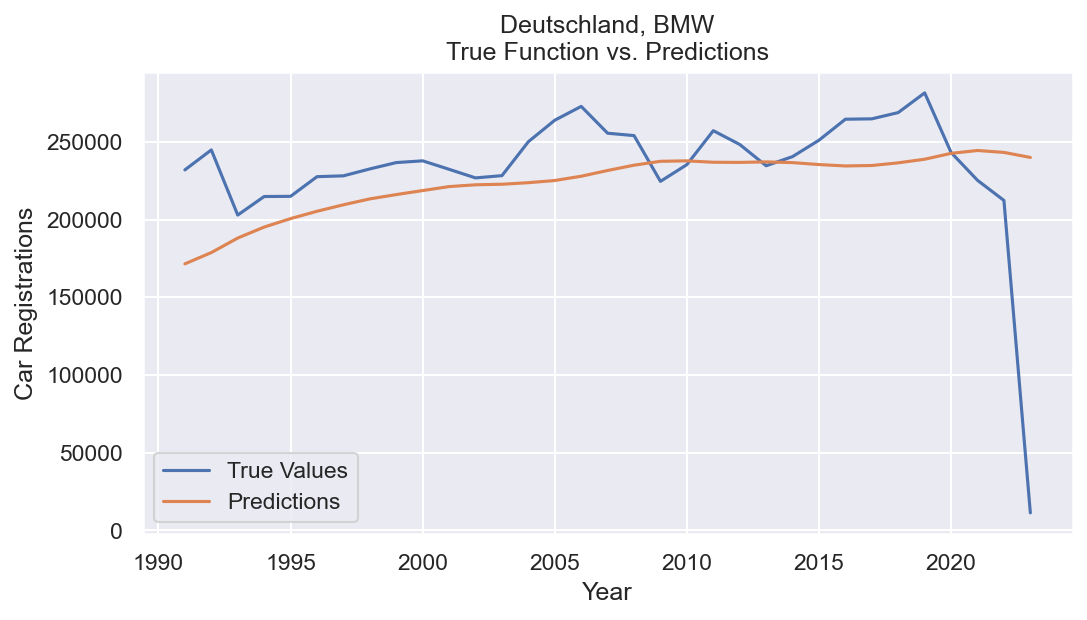

In [29]:
# Plot the true function and predictions:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(predictions_years.year, true_values, label='True Values')
plt.plot(predictions_df['Year'], predictions_df['Predicted Car Registrations'], label='Predictions')
plt.xlabel('Year')
plt.ylabel('Car Registrations')
plt.title(f'{country}, {brand}\nTrue Function vs. Predictions')
plt.legend()
plt.grid(True)

# Save the plot as an image
filename = f'Predictions-{country}-{brand}.png'
plt.savefig(filename)

# Show a confirmation message
print(f"Plot saved as {filename}")

In [30]:
os.chdir("../")

In [31]:
os.chdir("data")

In [33]:
# Round the predicted car registrations to integers
rounded_predictions = predictions.flatten().astype(int)

# Create a DataFrame with predictions and true values
predictions_df = pd.DataFrame({
    'Year': predictions_years.year,
    'Predicted Car Registrations': rounded_predictions.flatten(),
    'True Car Registrations': true_values
})

# Save the predictions to a CSV file
filename = f'Predictions_{country}_{brand}.csv'
predictions_df.to_csv(filename, index=False)
print(f'Predictions saved to {filename}')

os.chdir("../")

Predictions saved to Predictions_Deutschland_BMW.csv
